In [1]:
from transforms import Deslant
from torchvision.transforms import Compose
from dataset import CTCData
import cv2
import matplotlib.pyplot as plt

In [2]:
def show_img(img):
    cv2.imshow('', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def plot_img(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def bounding_box(x1,y1,x2,y2,img):
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

In [3]:
import pandas as pd
import os
df = pd.read_csv('../../Dataset/DIDA/DIDA_Label1.csv').astype(str)
word_df=df
chars = []
word_col=-1
word_df.iloc[:, word_col].apply(lambda x: chars.extend(list(x)))
# 
# chars = sorted(list(set(chars)))
# char_dict = {c:i for i, c in enumerate(chars, 1)}

0       None
1       None
2       None
3       None
4       None
        ... 
1855    None
1856    None
1857    None
1858    None
1859    None
Name: word, Length: 1860, dtype: object

In [4]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [5]:
#Xử lý ảnh
# path="../../Dataset/Cinanmon/HandWriting/all/"
# path2="../../Dataset/Cinanmon/HandWriting/all_2/"

# for filename in os.listdir(path):
#     full_path=os.path.join(path,filename)
#     img=cv2.imread(full_path)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     thresh=thresholding(gray)
#     cv2.imwrite(path2+filename,thresh)

In [6]:
batch_size=50

In [7]:
from dataset import CTCData
from dataloader import CTCDataLoader
from transforms import Rescale, Deslant, toRGB, ToTensor, Normalise
from torchvision.transforms import Compose
import torch

# use gpu if available
dev = "cuda" if torch.cuda.is_available() else "cpu"
# dev="cpu"
# create the CTCDataset
csv_name="label_all.csv"
data_path="../../Dataset/Cinanmon/HandWriting/all_2/"
dataset = CTCData(csv_file=csv_name,                                               # csv name
        root_dir=data_path,  # root directory of csv and images
                  transform=Compose([                                                     # compose sequence of transforms
                   # Deslant(),                                                           # Deslant whole dataset before.
                     Rescale(output_size=(64, 800),                                       # one key part is that the image
                            random_pad=True,                                              # is rotated 90 degrees (w, h)
                            border_pad=(4, 10), 
                            random_rotation=2,                                            # random angle rotation (+/-)
                            random_stretch=1.2),                                          # randomly stretch the line (up to)
                     toRGB(),                                                            # converted to RGB - imagenet 
                     ToTensor(rgb=True),                                                 # was 3 channel images
                      Normalise(mean=[0.485, 0.456, 0.406],                              # pretrained resnet
                                  std=[0.229, 0.224, 0.225])]))                          # must use imagenet stats!

# Create a dataloader
dl = CTCDataLoader(dataset,                                                              # pass the dataset
                   batch_size=(batch_size,batch_size*2),                                                 # train batchsize, val batchsize
                   validation_split=0.2,                                                 # size of validation split [0-1]
                   shuffle=True,                                                         # shuffle the dataset
                   seed=42,                                                              # random seed - for reproducibility
                   device=dev)                                                           # on CPU or GPU?

In [8]:
print("max_len: ", dataset.max_len)
print("char_dict: ",dataset.char_dict)

max_len:  69
char_dict:  {' ': 1, '#': 2, "'": 3, '(': 4, ')': 5, '+': 6, ',': 7, '-': 8, '.': 9, '/': 10, '0': 11, '1': 12, '2': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20, ':': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, 'L': 33, 'M': 34, 'N': 35, 'O': 36, 'P': 37, 'Q': 38, 'R': 39, 'S': 40, 'T': 41, 'U': 42, 'V': 43, 'W': 44, 'X': 45, 'Y': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'g': 52, 'h': 53, 'i': 54, 'k': 55, 'l': 56, 'm': 57, 'n': 58, 'o': 59, 'p': 60, 'q': 61, 'r': 62, 's': 63, 't': 64, 'u': 65, 'v': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70, 'Â': 71, 'Ê': 72, 'Ô': 73, 'à': 74, 'á': 75, 'â': 76, 'ã': 77, 'è': 78, 'é': 79, 'ê': 80, 'ì': 81, 'í': 82, 'ò': 83, 'ó': 84, 'ô': 85, 'õ': 86, 'ù': 87, 'ú': 88, 'ý': 89, 'ă': 90, 'Đ': 91, 'đ': 92, 'ĩ': 93, 'ũ': 94, 'Ơ': 95, 'ơ': 96, 'ư': 97, 'ạ': 98, 'ả': 99, 'ấ': 100, 'ầ': 101, 'ẩ': 102, 'ẫ': 103, 'ậ': 104, 'ắ': 105, 'ằ': 106, 'ẵ': 107, 'ặ': 108, 'ẹ

In [9]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [10]:
from model import CTCModel
model = CTCModel(chan_in=3,                                                             # 3 channel image - imagenet pretrained
                 time_step=96,                                                          # this is the max length possible                                                  
                 feature_size=512,                                                      # conv outputs 512, 32, 1
                 hidden_size=512,                        
                output_size=len(dataset.char_dict) + 1,                                 # output matrix has to have col for each letter
                 num_rnn_layers=4,                                                      # plus 1 for special blank character 
                 rnn_dropout=0)
model.load_pretrained_resnet()                                                          # load some pretrained weights
model.to(dev)                                                                           # put the model parameters on CPU/GPU

CTCModel(
  (cnn): CNN(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
    (relu): ReLU(inplace=True)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [11]:
# #For word_train
# from model import CTCModel
# from learn import Learner
# model = CTCModel(chan_in=3, 
#                 time_step=32, 
#                 feature_size=512, 
#                 hidden_size=512,
#                 output_size=len(dataset.char_dict) + 1, 
#                 num_rnn_layers=4, rnn_dropout=0)

# model.load_pretrained_resnet()                                                          # load some pretrained weights
# model.to(dev)   
# learn = Learner(model=model,                                                           
#                 dataloader=dl, # if you don't wish to train this can be lambda: (None, None)/Dataset and dataloader skipped.
#                 decode_map={v:k for k,v in dataset.char_dict.items()})   

# learn.load(f='weights/word/word.pth',                                                 
#            inv_f='weights/word/word_decode.pk',                                      
#            load_decode=False,                                                          
#            keep_LSTM=False,
#            freeze_conv=True)



In [12]:
# #For line train
# from model import CTCModel
# from learn import Learner
# model = CTCModel(chan_in=3, 
#                 time_step=32, 
#                 feature_size=512, 
#                 hidden_size=512,
#                 output_size=len(dataset.char_dict) + 1, 
#                 num_rnn_layers=4, rnn_dropout=0)

# model.load_pretrained_resnet()                                                          # load some pretrained weights
# model.to(dev)   
# learn = Learner(model=model,                                                           
#                 dataloader=dl, # if you don't wish to train this can be lambda: (None, None)/Dataset and dataloader skipped.
#                 decode_map={v:k for k,v in dataset.char_dict.items()})   

# learn.load(f='weights/line/lines.pth',                                                 
#            inv_f='weights/line/line_decode.pkl',                                      
#            load_decode=False,                                                          
#            keep_LSTM=False,
#            freeze_conv=True)


/home/vuong/Anh_Hung/OCR/OCR-handwritten/pytorch-ocr/transforms.py:129: FutureWarning: grey2rgb is deprecated. It will be removed in version 0.19.Please use gray2rgb instead.
  image = color.grey2rgb(image)


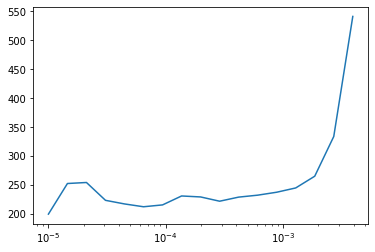

In [13]:
#Vietnamese
from learn import Learner
learn = Learner(model=model,                                                           
                dataloader=dl,                                                         
               decode_map={v:k for k,v in dataset.char_dict.items()})                  # inverse of char_dict

learn.load(f='weights/vietnamese_text/model_text.pth',                                                 
           inv_f='weights/vietnamese_text/decode_map_text.pk',                                      
           load_decode=False,                                                          
           keep_LSTM=True,
           freeze_conv=True)

learn.freeze()                                                                         # freeze the conv weights
log, lr = learn.find_lr(start_lr=1e-5, end_lr=1e1, wd=0.1)                             # find a suitable learning rate
#                                                                                        # wd = weight decay
# # based on https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

In [14]:
# first run - frozen - just a demo - want to do more epochs if actual training
print('Training with ResNet parameters frozen')
learn.fit_one_cycle(epochs=30, max_lr=1e-3, base_lr=1e-4, wd=0.1)

# unfreeze all weights
print('Training with all parameters (CNN + LSTM) unfrozen')
learn.unfreeze()
learn.fit_one_cycle(epochs=10, max_lr=1e-3, base_lr=1e-4, wd=0.1)

Training with ResNet parameters frozen
epoch 1: train loss 601.9879760742188 | valid loss 2456.630126953125 | CER 0.4140514874990726 | IER 0.9514767932489452
TRAIN LEVEN 0.038491695773041554 | VAL LEVEN 0.15305289709919134
epoch 2: train loss 266.52490234375 | valid loss 2386.813232421875 | CER 0.42510572000890273 | IER 0.9662447257383966
TRAIN LEVEN 0.033216156108759595 | VAL LEVEN 0.15060464426144374
epoch 3: train loss 226.56704711914062 | valid loss 2456.799560546875 | CER 0.4397581422954225 | IER 0.9683544303797469
TRAIN LEVEN 0.023895882227437593 | VAL LEVEN 0.15490763409748498
epoch 4: train loss 241.15711975097656 | valid loss 2490.333740234375 | CER 0.45292677498330736 | IER 0.9683544303797469
TRAIN LEVEN 0.02558189810477769 | VAL LEVEN 0.1597670450330143
epoch 5: train loss 263.0116271972656 | valid loss 2576.7236328125 | CER 0.41431115067883373 | IER 0.9493670886075949
TRAIN LEVEN 0.021581181209984892 | VAL LEVEN 0.1584316343942429
epoch 6: train loss 280.2973327636719 | val

In [15]:
learn.save(f='weights/vietnamese_text/model_text.pth',inv_f='weights/vietnamese_text/decode_map_text.pk')

In [22]:
x,y=dl()

single batch prediction of train dataset


/home/vuong/Anh_Hung/OCR/OCR-handwritten/pytorch-ocr/learn.py:273: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  img = rgb2grey(img)


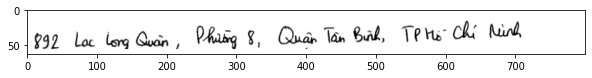

actual: 892 Lạc Long Quân, Phường 8, Quận Tân Bình, TP Hồ Chí Minh
pred:   892 Lạc Long Quân, Phường 8, Quận Tân Bình, TP Hồ Chí Minh


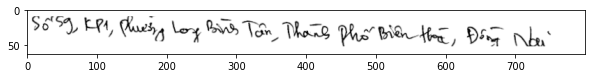

actual: Số 59, KP 1, Phường Long Bình Tân, Thành Phố Biên Hoà, Đồng Nai
pred:   Số 59, KP 1, Phường Long Bình Tân, Thành Phố Biên Hoà, Đồng Nai


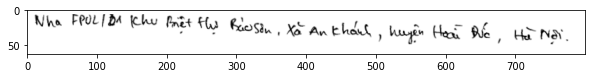

actual: Nhà FB02/61 Khu Biệt thự Bảo Sơn, Xã An Khánh, Huyện Hoài Đức, Hà Nội
pred:   Nhà FB02/61 Khu Biệt thự Bảo Sơn, Xã An Khánh, Huyện Hoài Đức, Hà Nội


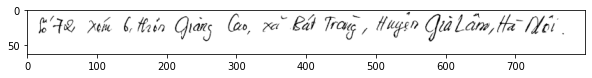

actual: Số 72, xóm 6, thôn Giang Cao, xã Bát Tràng, Huyện Gia Lâm, Hà Nội
pred:   Số 72, xóm 6, thôn Giang Cao, xã Bát Tràng, Huyện Gia Lâm, Hà Nội


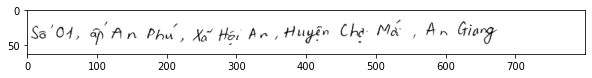

actual: Số 01, ấp An Phú, Xã Hội An, Huyện Chợ Mới, An Giang
pred:   Số 01, ấp An Phú, Xã Hội An, Huyện Chợ Mới, An Giang
single batch prediction of valid dataset


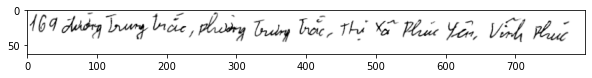

actual: 169 đường Trung Trắc, Phường Trưng Trắc, Thị Xã Phúc Yên, Vĩnh Phúc
pred:   169 đường Trung Trải, Phường Trưng Trải, Thị xã Phúc Yên, Vĩnh Phúc


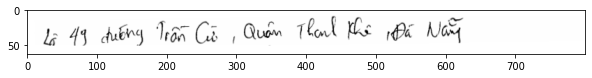

actual: Lô 49 đường Trần Cừ, Quận Thanh Khê, Đà Nẵng
pred:   Lô 49 đường Trên Cử, Quận Thanh Khê, Đà Nẵng


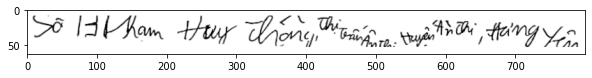

actual: Số 13 Phạm Huy Thông, Thị Trấn Ân Thi, Huyện Ân Thi, Hưng Yên
pred:   Số 1 dâm Huy Tng, Thị rấn ứon, Huyện lan, Hưng Yên


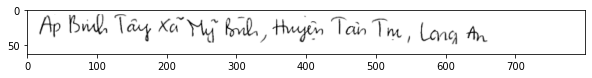

actual: Âp Bình Tây Xã Mỹ Bình, Huyện Tân Trụ, Long An
pred:   Ap Bình Tây, Xã Mỹ Bình, Huyện Tân Trự, Long An


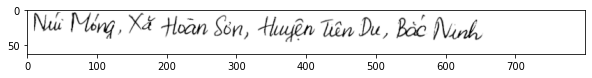

actual: Núi Móng, Xã Hoàn Sơn, Huyện Tiên Du, Bắc Ninh
pred:   Nhà Nàng, Xã Hom Sơn, Huyện Tiên Du, Bắc Ninh


In [30]:
learn.batch_predict(show_img=True, up_to=5,dataloader="both")

In [36]:
#Xử lý ảnh
path="images/"
path2="demo/"

for filename in os.listdir(path):
    full_path=os.path.join(path,filename)
    img=cv2.imread(full_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh=thresholding(gray)
    cv2.imwrite(path2+filename,thresh)
# learn.predict(img_path='images/output_17_15.png',show_img=True,transforms=ToTensor())